# 🎈 Deep Learning Workshop: Introduction to Convolutional Neural Networks (CNNs)
 In this workshop, you'll learn the fundamentals of Convolutional Neural Networks (CNNs), the powerful models that have revolutionized how computers "see" the world.

We'll cover the core concepts, build a simple CNN from scratch to classify clothing items, and then tackle two exciting challenges:

The Optimizer Race: You'll compare how different optimization algorithms affect model training.

Build a ResNet: You'll implement a famous and powerful deep learning architecture, ResNet-18, from the ground up.

Let's begin our journey into the world of computer vision! 🚀

# Part 1: Core Concepts of CNNs 🌌
Before we code, let's understand the main building blocks of a CNN. Think of a CNN as an assembly line where an image goes through several stations (layers), each performing a specific task to identify its features.

Convolutional Layers: This is the heart of a CNN. It uses small filters called kernels that slide across the image to detect basic features like edges, corners, and textures. This process creates "feature maps" that highlight where these patterns occur.

Activation Functions (ReLU): After each convolution, an activation function like ReLU (Rectified Linear Unit) is applied. It introduces non-linearity, which allows the network to learn more complex and abstract patterns beyond simple lines. ReLU is very efficient—it simply changes all negative pixel values in the feature map to zero.

Pooling Layers: These layers shrink the feature maps, making the network faster and helping it focus on the most important information. Max Pooling is the most common type; it slides a window over the feature map and takes only the maximum pixel value from each window.

Flattening & Fully Connected Layers: After several convolution and pooling stages, the final 2D feature maps are "flattened" into a single, long 1D vector. This vector is then fed into fully connected layers, which act like a traditional neural network to make a final decision and classify the image.

🧷 For a deeper dive, check out these excellent resources:

https://www.ibm.com/think/topics/convolutional-neural-networks

https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939/

# Part 2: A Hands-On Example with Fashion-MNIST 🛹
Let's build our first CNN to classify images from the Fashion-MNIST dataset. This dataset contains 70,000 grayscale images (28x28 pixels) of 10 types of clothing.

Step 1: Setup and Imports
First, we'll import the necessary libraries and set up our device for training (GPU if available, otherwise CPU).

In [1]:
# Import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# Check if CUDA (GPU) is available and set the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


Step 2: Loading and Visualizing the Data

Next, we load the Fashion-MNIST dataset. We'll convert the images to PyTorch tensors and normalize their pixel values. Normalization helps the model train more efficiently.

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.93MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 175kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.24MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.1MB/s]


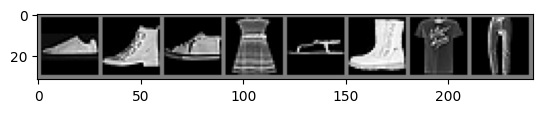

Sneaker Ankle boot Sneaker Dress Sandal Ankle boot T-shirt/top Trouser


In [2]:
# Define the transformation pipeline for the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Mean and std for grayscale
])

# Load the training and test datasets
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Class labels for Fashion-MNIST
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# --- Let's visualize some images ---
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

Step 3: Defining the CNN Architecture
Here is a simple CNN architecture.

Each layer is commented to explain its purpose and how the image dimensions change as they pass through the network.

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Input images are 28x28 grayscale

        # Convolutional Layer 1: 1 input channel, 16 output channels, 3x3 kernel
        # Output: (28 - 3 + 2*1)/1 + 1 = 28 -> 16x28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Max Pooling Layer 1: 2x2 kernel, stride 2
        # Output: 16x14x14
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Layer 2: 16 input channels, 32 output channels, 3x3 kernel
        # Output: (14 - 3 + 2*1)/1 + 1 = 14 -> 32x14x14
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Max Pooling Layer 2: 2x2 kernel, stride 2
        # Output: 32x7x7
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layer: 32 * 7 * 7 = 1568 input features, 128 output features
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        # Output Layer: 128 input features, 10 output classes
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply Conv1 -> ReLU -> Pool1
        x = self.pool1(F.relu(self.conv1(x)))
        # Apply Conv2 -> ReLU -> Pool2
        x = self.pool2(F.relu(self.conv2(x)))

        # Flatten the output for the fully connected layer
        x = x.view(-1, 32 * 7 * 7)

        # Apply FC1 -> ReLU
        x = F.relu(self.fc1(x))
        # Apply final output layer
        x = self.fc2(x)
        return x

Step 4: Creating a Reusable Training Function

To keep our code clean and make it easy to run multiple experiments, we'll define a function that handles both training and validation for one epoch.

In [3]:
def train_and_validate(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


def validate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = val_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

Step 5: The Training Loop

Now we'll initialize our model and optimizer and run the main training loop for a few epochs.

In [5]:
# Initialize the network, loss function, and optimizer
net = SimpleCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Lists to store results
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}
num_epochs = 15

print("Starting Training...")
start_time = time.time()

for epoch in range(num_epochs):
    train_loss, train_acc = train_and_validate(net, trainloader, optimizer, criterion)
    val_loss, val_acc = validate(net, testloader, criterion)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

end_time = time.time()
print(f"\nFinished Training in {(end_time - start_time):.2f} seconds")

Starting Training...
Epoch 1/15 - Train Loss: 1.0543, Train Acc: 65.74% | Val Loss: 0.6094, Val Acc: 78.38%
Epoch 2/15 - Train Loss: 0.5266, Train Acc: 81.01% | Val Loss: 0.5221, Val Acc: 80.64%
Epoch 3/15 - Train Loss: 0.4433, Train Acc: 84.14% | Val Loss: 0.4304, Val Acc: 84.76%
Epoch 4/15 - Train Loss: 0.4044, Train Acc: 85.59% | Val Loss: 0.4018, Val Acc: 85.41%
Epoch 5/15 - Train Loss: 0.3819, Train Acc: 86.33% | Val Loss: 0.3893, Val Acc: 85.90%
Epoch 6/15 - Train Loss: 0.3635, Train Acc: 87.04% | Val Loss: 0.4014, Val Acc: 85.58%
Epoch 7/15 - Train Loss: 0.3479, Train Acc: 87.62% | Val Loss: 0.3597, Val Acc: 87.09%
Epoch 8/15 - Train Loss: 0.3336, Train Acc: 88.03% | Val Loss: 0.3497, Val Acc: 87.45%
Epoch 9/15 - Train Loss: 0.3211, Train Acc: 88.53% | Val Loss: 0.3366, Val Acc: 87.96%
Epoch 10/15 - Train Loss: 0.3146, Train Acc: 88.71% | Val Loss: 0.3330, Val Acc: 87.78%
Epoch 11/15 - Train Loss: 0.3027, Train Acc: 89.15% | Val Loss: 0.3709, Val Acc: 86.17%
Epoch 12/15 - Train 

Step 6: Evaluation

Let's plot the training curves to visualize the model's performance over time.

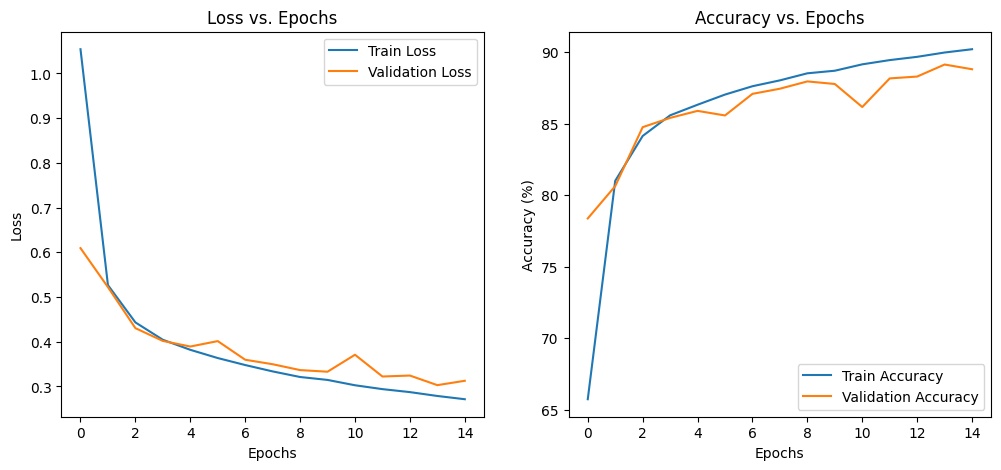

In [6]:
# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Part 3: Challenge 1 - The Great Optimizer Race! 🚀
Optimizers are the algorithms that fine-tune your model's weights to minimize error. The choice of optimizer can drastically change your training speed and final accuracy.

Your challenge is to compare the performance of different optimizers by training our SimpleCNN model on Fashion-MNIST.



# Task

Train the SimpleCNN model using each optimizer below for 10 epochs. For each one, you must re-initialize the model to ensure a fair comparison. Record the validation accuracy after epochs 1, 5, and 10, and the total training time.

Optimizers to test:

optim.SGD(net.parameters(), lr=0.001)

optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

optim.RMSprop(net.parameters(), lr=0.001)

optim.Adam(net.parameters(), lr=0.001)

Fill in the #TODO sections below to set up and run the experiments.

In [7]:
optimizers_to_test = {
    "SGD": optim.SGD,
    "SGD+Momentum": optim.SGD,
    "RMSprop": optim.RMSprop,
    "Adam": optim.Adam
}

optimizer_params = {
    "SGD": {"lr": 0.001},
    "SGD+Momentum": {"lr": 0.001, "momentum": 0.9},
    "RMSprop": {"lr": 0.001},
    "Adam": {"lr": 0.001}
}

results = {}
num_epochs_challenge = 10

for name, optimizer_class in optimizers_to_test.items():
    print(f"\n--- Training with {name} ---")

    # --- IMPORTANT: Re-initialize the model for each experiment ---
    net = SimpleCNN().to(DEVICE)

    # TODO: Define the optimizer using optimizer_class and the params from optimizer_params
    optimizer = optimizer_class(net.parameters(), **optimizer_params[name])

    criterion = nn.CrossEntropyLoss()

    # Store history for this optimizer
    history = {'val_loss': [], 'val_acc': []}

    start_time = time.time()
    for epoch in range(num_epochs_challenge):
        train_loss, train_acc = train_and_validate(net, trainloader, optimizer, criterion)
        val_loss, val_acc = validate(net, testloader, criterion)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs_challenge} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    end_time = time.time()

    # Store the results
    results[name] = {
        'val_acc_ep1': history['val_acc'][0],
        'val_acc_ep5': history['val_acc'][4],
        'val_acc_ep10': history['val_acc'][9],
        'time': end_time - start_time
    }

print("\n--- All experiments complete! ---")


--- Training with SGD ---
Epoch 1/10 - Val Loss: 2.2023, Val Acc: 34.82%
Epoch 2/10 - Val Loss: 1.7419, Val Acc: 59.17%
Epoch 3/10 - Val Loss: 1.0127, Val Acc: 68.86%
Epoch 4/10 - Val Loss: 0.7817, Val Acc: 72.99%
Epoch 5/10 - Val Loss: 0.7005, Val Acc: 75.03%
Epoch 6/10 - Val Loss: 0.6511, Val Acc: 76.66%
Epoch 7/10 - Val Loss: 0.6221, Val Acc: 77.44%
Epoch 8/10 - Val Loss: 0.5959, Val Acc: 78.35%
Epoch 9/10 - Val Loss: 0.5786, Val Acc: 79.20%
Epoch 10/10 - Val Loss: 0.5570, Val Acc: 79.72%

--- Training with SGD+Momentum ---
Epoch 1/10 - Val Loss: 0.6165, Val Acc: 77.63%
Epoch 2/10 - Val Loss: 0.5738, Val Acc: 77.06%
Epoch 3/10 - Val Loss: 0.4713, Val Acc: 82.53%
Epoch 4/10 - Val Loss: 0.4060, Val Acc: 85.26%
Epoch 5/10 - Val Loss: 0.4072, Val Acc: 85.05%
Epoch 6/10 - Val Loss: 0.3831, Val Acc: 85.56%
Epoch 7/10 - Val Loss: 0.3871, Val Acc: 85.26%
Epoch 8/10 - Val Loss: 0.3488, Val Acc: 87.50%
Epoch 9/10 - Val Loss: 0.3432, Val Acc: 87.71%
Epoch 10/10 - Val Loss: 0.3372, Val Acc: 87

After running all experiments, answer the analysis questions.


1.Analysis Questions:
Which optimizer achieved the highest validation accuracy after 10 epochs?

2.Which optimizer converged the fastest (i.e., reached a high accuracy in the fewest epochs)?

3.Based on your results, which optimizer seems to be the most effective overall for this problem? Why might that be?



**Q.** Analysis Questions: Which optimizer achieved the highest validation accuracy after 10 epochs?

**A.** Adam Optimizer

**Q.** Which optimizer converged the fastest (i.e., reached a high accuracy in the fewest epochs)?

**A.** Adam Optimizer

**Q.** Based on your results, which optimizer seems to be the most effective overall for this problem? Why might that be?

**A.** Adam Optimizer. Adam Optimizer has adaptive learning rate mechanism based on 2 factors:
- The **first moment ($m_t$)** tracks the mean of gradients to provide momentum.
- The **second moment ($v_t$)** tracks squared gradients, enabling Adam to normalize updates and prevent sudden changes in direction.

# Part 4: Advanced Challenge - Build a ResNet from Scratch! 🏆
For our final challenge, you will implement a famous and powerful deep learning architecture, ResNet-18, from scratch. We'll train it on the Street View House Numbers (SVHN) dataset, which is a real-world dataset of colored digit images.

# Step 1: Data Loading for SVHN
The SVHN dataset contains 32x32 color images. Since ResNet architectures are designed for larger images, we'll resize them to the standard 224x224.

In [4]:
# Define transforms for the SVHN dataset
svhn_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the SVHN dataset
svhn_trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=svhn_transform)
svhn_trainloader = torch.utils.data.DataLoader(svhn_trainset, batch_size=32, shuffle=True)

svhn_testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=svhn_transform)
svhn_testloader = torch.utils.data.DataLoader(svhn_testset, batch_size=32, shuffle=False)

100%|██████████| 182M/182M [00:02<00:00, 66.3MB/s]
100%|██████████| 64.3M/64.3M [00:01<00:00, 52.3MB/s]


Step 2: Build the ResNet-18 Model

Now, let's build the ResNet-18 architecture. It's composed of BasicBlock modules that contain the special "residual connections." Your task is to fill in the #TODO sections to complete the model.

In [5]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # TODO: Define the four main layers using the _make_layer helper function
        # For ResNet-18, `layers` is [2, 2, 2, 2]
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # TODO: Define the final classifier layer (output size should be num_classes)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layer_blocks = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layer_blocks.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layer_blocks)

    def forward(self, x):
        # TODO: Implement the full forward pass
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Create an instance of your ResNet-18 model for 10 classes
# TODO: Pass the correct arguments to instantiate the model
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)

Step 3: Train and Evaluate Your ResNet

Finally, initialize your model and train it using the train_and_validate function. This task is more computationally intensive, so training for just 5 epochs is enough to see how well it works.

In [ ]:
# Setup device, criterion, and a suitable optimizer (Adam is a good choice)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

# Train the model
resnet_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
num_epochs_resnet = 5

print("Starting ResNet-18 Training on SVHN...")
start_time = time.time()

for epoch in range(num_epochs_resnet):
    train_loss, train_acc = train_and_validate(model_resnet, svhn_trainloader, optimizer, criterion)
    val_loss, val_acc = validate(model_resnet, svhn_testloader, criterion)

    resnet_history['train_loss'].append(train_loss)
    resnet_history['train_acc'].append(train_acc)
    resnet_history['val_loss'].append(val_loss)
    resnet_history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs_resnet} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

end_time = time.time()
print(f"\nFinished Training in {(end_time - start_time):.2f} seconds")


# Plot the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(resnet_history['train_loss'], label='Train Loss')
plt.plot(resnet_history['val_loss'], label='Validation Loss')
plt.title('ResNet-18 Loss on SVHN')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(resnet_history['train_acc'], label='Train Accuracy')
plt.plot(resnet_history['val_acc'], label='Validation Accuracy')
plt.title('ResNet-18 Accuracy on SVHN')
plt.legend()
plt.show()

Starting ResNet-18 Training on SVHN...
Epoch 1/5 - Train Loss: 1.1359, Train Acc: 61.25% | Val Loss: 0.3078, Val Acc: 91.07%
